<a href="https://colab.research.google.com/github/robbieyyy/robbieyyy.github.io/blob/main/Optimisation_For_ABM_Calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Initial Model Set-up

In [1]:
import pandas as pd
import numpy as np
# Paths to datasets
dataset_paths = {
    'AAPL': '/content/AAPL.csv',
    'IXIC': '/content/IXIC.csv',
    'NVDA': '/content/NVDA.csv',
    'SPX': '/content/SPX.csv',
    'GOOG': '/content/GOOG.csv',
    'GBPUSD': '/content/GBPUSD=X.csv',
    'EURUSD': '/content/EURUSD=X.csv',
    'AUDUSD': '/content/AUDUSD=X.csv'
    }
# Loading datasets into a dictionary
datasets = {name: pd.read_csv(path) for name, path in dataset_paths.items()}

# Ensuring all datasets have the same format
for name, data in datasets.items():
    if not all(col in data.columns for col in ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']):
        raise ValueError(f"Dataset {name} is missing required columns.")

In [2]:
!python --version

Python 3.10.12


# Step 2: Defining Agent Behaviour

In [3]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import mean_squared_error
from gym import Env, spaces

In [4]:
# Defining Trading Environment
class TradingEnv(Env):
    def __init__(self, data):
        # super to call parent class (TradingEnv)
        super(TradingEnv, self).__init__()
        self.data = data.copy()
        self.current_step = 0
        # Conditions of environment /Actions: 0 = hold, 1 = buy, 2 = sell
        self.action_space = spaces.Discrete(3)
        # Defines the observation space as a continuous space with a shape based on the number of columns in the data.
        self.observation_space = spaces.Box(low=0, high=1, shape=(len(data.columns),), dtype=np.float32)
        self.holdings = 0
        self.balance = 1000

    # Resets the environment to its initial state, returning the first row of data as the initial observation.
    def reset(self):
        self.current_step = 0
        self.holdings = 0
        self.balance = 1000
        # Returns the data at the initial step (self.current_step = 0) as an observation. The .values converts the DataFrame row into a NumPy array.
        return self.data.iloc[self.current_step].values

    def step(self, action):
        self.current_step += 1
        # Checks if the current step has reached the end of the data. If true, done is set to True, indicating the episode is over.
        done = self.current_step >= len(self.data) - 1

        # Current price and initial balance
        # Retrieves the closing price of the stock at the current step.
        current_price = self.data.iloc[self.current_step]['Close']
        initial_balance = self.balance

        # Simulating price changes based on the trader's action
        price_change = 0
        if action == 1:  # Buy
            self.holdings += 1
            # Simulates a price increase of 0.5% due to buying pressure.
            price_change = current_price * 0.005
        elif action == 2:  # Sell
            if self.holdings > 0:
                self.holdings -= 1
                price_change = -current_price * 0.005  # Price decrease due to selling

        # Updating the price in the data
        self.data.at[self.current_step, 'Close'] += price_change
        # Updates the agent's balance by subtracting the cost associated with the price change.
        self.balance += price_change * self.holdings

        # Reward is the change in net worth
        net_worth = self.balance + self.holdings * self.data.iloc[self.current_step]['Close']
        # Calculates the reward as the change in balance since the last step.
        reward = net_worth - initial_balance
        # Retrieves the data at the next step as a NumPy array.
        obs = self.data.iloc[self.current_step].values

        # Returns the observation (next_observation), the reward (reward), whether the episode is done (done), and an empty info dictionary.
        return obs, reward, done, {}

    # Defines a render method, which would normally be used to visualize the environment, but it's left as a placeholder (pass) in this implementation.
    def render(self, mode='human'):
        pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Traders
class FundamentalTrader:
    def __init__(self, fundamental_value, sensitivity=0.05):
        self.fundamental_value = fundamental_value
        self.sensitivity = sensitivity

    # Defines a method that takes the current price as input and returns an action.
    def decide(self, price):
        # Checks if the current price is significantly below the fundamental value (by more than 5%), indicating an opportunity to buy.
        if price < self.fundamental_value * (1 - self.sensitivity):
            # If the condition is met, the trader decides to buy (1).
            return 1  # Buy
        elif price > self.fundamental_value * (1 + self.sensitivity):
            return 2  # Sell
        else:
            return 0  # Hold

In [6]:
class MomentumTrader:
    def __init__(self, trend_length=3):
        # Trend_length determines how many recent prices will be used to detect trends.
        self.trend_length = trend_length
        self.recent_prices = []

    def decide(self, price):
        # Adds the current price to the list of recent prices.
        self.recent_prices.append(price)
        # Checks if the number of stored prices exceeds the trend length.
        if len(self.recent_prices) > self.trend_length:
            self.recent_prices.pop(0)

        if len(self.recent_prices) < self.trend_length:
            return 0  # Hold

        if all(x < y for x, y in zip(self.recent_prices, self.recent_prices[1:])):
            return 1  # Buy
        elif all(x > y for x, y in zip(self.recent_prices, self.recent_prices[1:])):
            return 2  # Sell
        else:
            return 0  # Hold

In [7]:
class RandomTrader:
    def __init__(self):
        pass

    def decide(self, price):
        return np.random.choice([0, 1, 2])  # Randomly choose between hold, buy, sell

# Step 3: Calibration of Parameters




In [8]:
# Distance Function
def distance_function(real_data, synthetic_data):
    real_prices = real_data['Close'].values
    synthetic_prices = synthetic_data['Close'].values
    return mean_squared_error(real_prices, synthetic_prices)


# Generating Synthetic Data
def generate_synthetic_data(trader_classes, data):
    env = TradingEnv(data)
    state = env.reset()
    done = False

    # initialize trading env with real data, creates a simulation loop until trading is completed
    while not done:
        actions = [trader.decide(state[4]) for trader in trader_classes]
        action = max(set(actions), key=actions.count)
        state, reward, done, _ = env.step(action)

    # Converts the list of synthetic prices into a DataFrame.
    synthetic_data = pd.DataFrame({
        'Date': data['Date'],
        'Close': [env.data.iloc[i]['Close'] for i in range(len(data))]
    })
    return synthetic_data

In [9]:
datasets = {name: pd.read_csv(path) for name, path in dataset_paths.items()}

for name, real_data in datasets.items():
    # Adjusting based on dataset specifics
    real_data['Close'] = real_data['Adj Close']
    fundamental_trader = FundamentalTrader(fundamental_value=150)
    momentum_trader = MomentumTrader(trend_length=3)
    random_trader = RandomTrader()

    synthetic_data = generate_synthetic_data([fundamental_trader, momentum_trader, random_trader], real_data)

    # Debugging: Check if synthetic data is the same as real data
    if real_data['Close'].equals(synthetic_data['Close']):
        print(f"Synthetic data for {name} is identical to real data.")

    distance = distance_function(real_data, synthetic_data)
    print(f"Distance (MSE) between real and synthetic data for {name}: {distance}")

Distance (MSE) between real and synthetic data for IXIC: 1409.5215038946849
Distance (MSE) between real and synthetic data for SPX: 164.6360849115463


In [10]:
# Debugging: Print first few rows of real and synthetic data
print("Real Data (first 5 rows):")
# The .head() method is called on the real_data DataFrame, which returns the first five rows of the dataset.
print(real_data.head())

print("Synthetic Data (first 5 rows):")
print(synthetic_data.head())

# Example of using the distance function
for name, real_data in datasets.items():
    real_data['Close'] = real_data['Adj Close']  # Adjust based on dataset specifics
    fundamental_trader = FundamentalTrader(fundamental_value=150)
    momentum_trader = MomentumTrader(trend_length=3)
    random_trader = RandomTrader()

    synthetic_data = generate_synthetic_data([fundamental_trader, momentum_trader, random_trader], real_data)

    # Debugging: Check if synthetic data is the same as real data
    if real_data['Close'].equals(synthetic_data['Close']):
        print(f"Synthetic data for {name} is identical to real data.")

    # Synthetic data is updated based on the sells/buys based on the logic (0.005)
    distance = distance_function(real_data, synthetic_data)
    print(f"Distance (MSE) between real and synthetic data for {name}: {distance}")

Real Data (first 5 rows):
         Date         Open         High          Low        Close  \
0  2023-07-27  4598.259766  4607.069824  4528.560059  4537.410156   
1  2023-07-28  4565.750000  4590.160156  4564.009766  4582.229980   
2  2023-07-31  4584.819824  4594.220215  4573.140137  4588.959961   
3  2023-08-01  4578.830078  4584.620117  4567.529785  4576.729980   
4  2023-08-02  4550.930176  4550.930176  4505.750000  4513.390137   

     Adj Close      Volume  
0  4537.410156  4553210000  
1  4582.229980  3981010000  
2  4588.959961  4503600000  
3  4576.729980  4042370000  
4  4513.390137  4270710000  
Synthetic Data (first 5 rows):
         Date        Close
0  2023-07-27  4537.410156
1  2023-07-28  4582.229980
2  2023-07-31  4588.959961
3  2023-08-01  4599.613630
4  2023-08-02  4513.390137


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Distance (MSE) between real and synthetic data for IXIC: 1354.2510985119984
Distance (MSE) between real and synthetic data for SPX: 131.43644783479044


# Step 4: Parameter Tuning


In [11]:
!pip install ipython-autotime

%load_ext autotime

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 388 µs (started: 2024-09-09 09:36:22 +00:00)


## 1. Grid Search:

In [12]:
from sklearn.metrics import mean_squared_error
# product generates the Cartesian product of input iterables, useful for grid search to try all combinations of parameters.
from itertools import product

def grid_search_tuning(trader_classes, param_grid, data):
    # Store best parameter.
    best_params = None
    # Starting infinity ensures any valid MSE will be lower to minimize MSE.
    best_mse = float('inf')

    # param_grid.values() returns a list of lists (one for each parameter).
    # product generates every possible combination of these lists.
    for params in product(*param_grid.values()):
        # Set parameters
        fundamental_value, sensitivity, trend_length = params
        trader_classes[0].fundamental_value = fundamental_value
        trader_classes[0].sensitivity = sensitivity
        trader_classes[1].trend_length = trend_length

        # Generate synthetic data and calculate MSE
        synthetic_data = generate_synthetic_data(trader_classes, data)
        mse = distance_function(data, synthetic_data)

        if mse < best_mse:
            best_mse = mse
            best_params = params

    return best_params, best_mse

time: 911 µs (started: 2024-09-09 09:36:22 +00:00)


In [13]:
# Define the parameter grid
# Defines the range of values for each parameter that will be tested during the grid search.
param_grid = {
    # When a trader tries to stimulate price, it is the initial value of the stock,
    # The parameter space in the fundamental value resembles the real-time stock data.
    # FV is constant, FV is the value where it started, trying to call the data wroth of the stock
    # FV is an instrinic value that trader believes the asset or stock should be worth based on the factors (finiancials) Fundamental is the price of the first
    'fundamental_value': [140, 150, 160],
    'sensitivity': [0.02, 0.05, 0.1],
    'trend_length': [3, 5, 7]
}

# Perform grid search on each dataset
for name, real_data in datasets.items():
    fundamental_trader = FundamentalTrader(fundamental_value=150)
    momentum_trader = MomentumTrader(trend_length=3)
    random_trader = RandomTrader()

    trader_classes = [fundamental_trader, momentum_trader, random_trader]
    best_params, best_mse = grid_search_tuning(trader_classes, param_grid, real_data)

    print(f"Best parameters for {name}: {best_params}")
    print(f"Best MSE for {name}: {best_mse}")

Best parameters for IXIC: (160, 0.05, 5)
Best MSE for IXIC: 36.62334452409617
Best parameters for SPX: (140, 0.02, 7)
Best MSE for SPX: 0.0
time: 12.5 s (started: 2024-09-09 09:36:22 +00:00)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


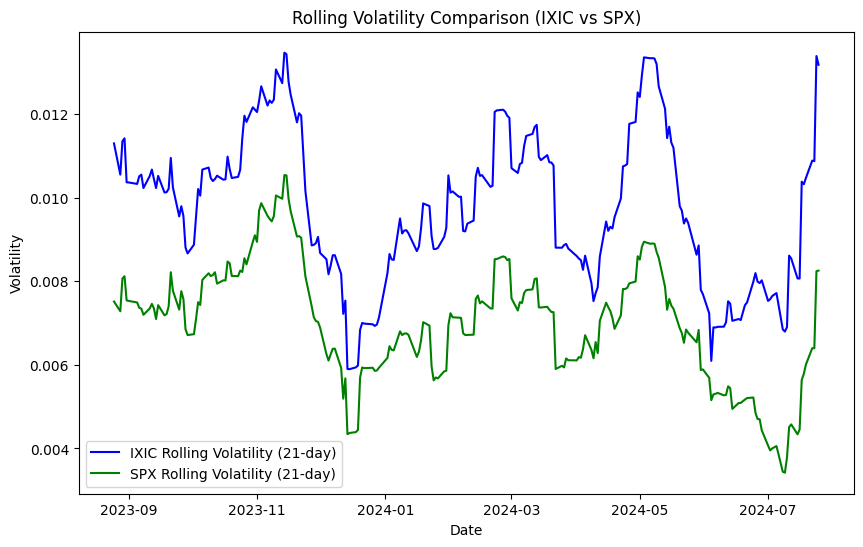

time: 1.11 s (started: 2024-09-09 10:02:25 +00:00)


In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

# Step 1: Load IXIC and SPX data from Yahoo Finance

ixic = yf.download('^IXIC', start='2023-07-27', end='2024-07-26')
spx = yf.download('^GSPC', start='2023-07-27', end='2024-07-26')  # ^GSPC is the ticker for the S&P 500

# Step 2: Calculate daily returns for both IXIC and SPX
ixic['Returns'] = ixic['Close'].pct_change()
spx['Returns'] = spx['Close'].pct_change()


# Step 3: Calculate rolling volatility (21-day window) for both IXIC and SPX
ixic['Rolling_Volatility'] = ixic['Returns'].rolling(window=21).std()
spx['Rolling_Volatility'] = spx['Returns'].rolling(window=21).std()


# Step 4: Plot the rolling volatility of both indices
plt.figure(figsize=(10, 6))
plt.plot(ixic.index, ixic['Rolling_Volatility'], label='IXIC Rolling Volatility (21-day)', color='blue')
plt.plot(spx.index, spx['Rolling_Volatility'], label='SPX Rolling Volatility (21-day)', color='green')

plt.title('Rolling Volatility Comparison (IXIC vs SPX)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

## 2. Random Search:

In [15]:
import random

def random_search_tuning(trader_classes, param_distributions, n_iter, data):
    best_params = None
    best_mse = float('inf')

    for _ in range(n_iter):
        # Sample parameters randomly
        # Randomly selects values for each parameter from the specified distributions.
        fundamental_value = random.choice(param_distributions['fundamental_value'])
        sensitivity = random.choice(param_distributions['sensitivity'])
        trend_length = random.choice(param_distributions['trend_length'])

        # Set parameters
        trader_classes[0].fundamental_value = fundamental_value
        trader_classes[0].sensitivity = sensitivity
        trader_classes[1].trend_length = trend_length

        # Generate synthetic data and calculate MSE
        synthetic_data = generate_synthetic_data(trader_classes, data)
        mse = distance_function(data, synthetic_data)

        if mse < best_mse:
            best_mse = mse
            best_params = (fundamental_value, sensitivity, trend_length)

    return best_params, best_mse

time: 1.32 ms (started: 2024-09-09 09:36:37 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# Define the parameter distributions
param_distributions = {
    'fundamental_value': [140, 150, 160],
    'sensitivity': [0.02, 0.05, 0.1],
    'trend_length': [3, 5, 7]
}

# Perform random search on each dataset
# n_iter determines how many random samples will be tested.
n_iter = 10
for name, real_data in datasets.items():
    fundamental_trader = FundamentalTrader(fundamental_value=150)
    momentum_trader = MomentumTrader(trend_length=3)
    random_trader = RandomTrader()

    trader_classes = [fundamental_trader, momentum_trader, random_trader]
    best_params, best_mse = random_search_tuning(trader_classes, param_distributions, n_iter, real_data)

    print(f"Best parameters for {name} with random search: {best_params}")
    print(f"Best MSE for {name} with random search: {best_mse}")

Best parameters for IXIC with random search: (150, 0.05, 3)
Best MSE for IXIC with random search: 146.0694967272429
Best parameters for SPX with random search: (160, 0.02, 3)
Best MSE for SPX with random search: 0.0
time: 4.13 s (started: 2024-09-09 09:36:37 +00:00)


## 3. Bayesian Optimization:

In [17]:
!pip install scikit-optimize

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time: 8.4 s (started: 2024-09-09 09:36:41 +00:00)


In [18]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.acquisition import gaussian_ei

def bayesian_optimization_tuning(trader_classes, data):
    # Define the parameter space
    # 130 to 170 because the probabilistic model
    # Set base to 130 because it is generic/average of all the stock prices
    # 1000 is the budget of the trader
    # Set below 200 because it will be above the budget of the trader in the trading env
    space  = [
        # Integer(3, 9, name='trend_length')
        Integer(140, 160, name='fundamental_value'),
        # Real cause sensitivity is continuous value
        Real(0.02, 0.1, name='sensitivity'),
        # Length cannot be more than 9 because rating is between 0 and 10
        # 3 is defined because 3 trading habits, buy sell or hold, to choose one of these to cross 3 times of the trend_length/observe 3 patterns to take the decision
        Integer(3, 7, name='trend_length')
    ]

    @use_named_args(space)
    def objective(**params):
        trader_classes[0].fundamental_value = params['fundamental_value']
        trader_classes[0].sensitivity = params['sensitivity']
        trader_classes[1].trend_length = params['trend_length']

        synthetic_data = generate_synthetic_data(trader_classes, data)
        return distance_function(data, synthetic_data)

    # gp_minimise, space is parameters space; n_calls is the number of evaluations; random_state is frequency of random data/best reproducability (based online for best output)
    # res = gp_minimize(objective, space, n_calls=20, random_state=42)
    # Use gp_minimize with Expected Improvement acquisition function
    res = gp_minimize(
        objective,
        space,
        n_calls=20,
        random_state=42,
        acq_func="EI"  # Use Expected Improvement as the acquisition function
    )

    return res.x, res.fun

time: 422 ms (started: 2024-09-09 09:36:50 +00:00)


In [19]:
# Perform Bayesian optimization on each dataset
for name, real_data in datasets.items():
    fundamental_trader = FundamentalTrader(fundamental_value=150)
    momentum_trader = MomentumTrader(trend_length=3)
    random_trader = RandomTrader()

    trader_classes = [fundamental_trader, momentum_trader, random_trader]
    # Runs Bayesian optimization on the real_data for the current dataset using the trader classes.
    best_params, best_mse = bayesian_optimization_tuning(trader_classes, real_data)

    print(f"Best parameters for {name} with Bayesian optimization: {best_params}")
    print(f"Best MSE for {name} with Bayesian optimization: {best_mse}")

Best parameters for IXIC with Bayesian optimization: [141, 0.061044568070712374, 5]
Best MSE for IXIC with Bayesian optimization: 84.1782034965867
Best parameters for SPX with Bayesian optimization: [152, 0.055666620228287306, 3]
Best MSE for SPX with Bayesian optimization: 0.0
time: 26 s (started: 2024-09-09 09:36:50 +00:00)


## 4. Greedy Search:

In [20]:
# A biased trading method because high risk for inaccuracy
def greedy_search(trader_classes, real_data):
    best_distance = float('inf')
    best_params = None

    # Define a small set of parameters to iterate through
    fundamental_values = [140, 150, 160]
    sensitivities = [0.02, 0.05, 0.1]
    trend_lengths = [3, 5, 7]


    # Iterate through all combinations possible to get the best value of the parameters
    for fundamental_value in fundamental_values:
      for trend_length in trend_lengths:
        for sensitivity in sensitivities:
            # Update trader parameters
            # Greedy is when it updates before synthetic data
            trader_classes[0].fundamental_value = fundamental_value
            trader_classes[0].sensitivity = sensitivity
            trader_classes[1].trend_length = trend_length


            # Generate synthetic data and calculate the distance
            synthetic_data = generate_synthetic_data(trader_classes, real_data)
            distance = distance_function(real_data, synthetic_data)

            if distance < best_distance:
                best_distance = distance
                best_params = (fundamental_value, trend_length, sensitivity)

    print(f"Best parameters: Fundamental value = {best_params[0]}, Sensitivity = {best_params[0]}, Trend length = {best_params[1]}")
    print(f"Best distance: {best_distance}")

time: 1.25 ms (started: 2024-09-09 09:37:16 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Example usage of greedy search
for name, real_data in datasets.items():
    print(f"\nGreedy search for {name} dataset")
    fundamental_trader = FundamentalTrader(fundamental_value=150)
    momentum_trader = MomentumTrader(trend_length=3)
    random_trader = RandomTrader()

    greedy_search([fundamental_trader, momentum_trader, random_trader], real_data)


Greedy search for IXIC dataset
Best parameters: Fundamental value = 150, Sensitivity = 150, Trend length = 5
Best distance: 44.37003477129032

Greedy search for SPX dataset
Best parameters: Fundamental value = 150, Sensitivity = 150, Trend length = 3
Best distance: 0.0
time: 14.2 s (started: 2024-09-09 09:37:16 +00:00)


## 5. Reinforcement Learning:

In [22]:
class QLearningAgent:
    # self= we; statespace= number of possible states in the env; actionspace= buy hold sell (0,1,2); alpha= learning rate, q value updated after each action
    # gamma= discount factor, controls future rewards and value; epsilon= how much have you explored all possible methods
    def __init__(self, state_space, action_space, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.q_table = np.zeros((state_space, action_space))
        self.alpha = alpha  # Learning rate, which controls how much new information overrides old information.
        self.gamma = gamma  # Discount factor, which determines the importance of future rewards.
        self.epsilon = epsilon  # Exploration rate, which controls the trade-off between exploration (trying new actions) and exploitation (using known actions).

    def choose_action(self, state):
        state = int(state)  # Convert state to an integer index
        # Generates a random number and compares it to epsilon. If it's less than epsilon, it explores by choosing a random action.
        if np.random.uniform(0, 1) < self.epsilon:
            # Chooses a random action from the action space if exploring.
            return np.random.choice(range(self.q_table.shape[1]))
        else:
            # Returns the action with the highest Q-value for the current state.
            return np.argmax(self.q_table[state])

    def update(self, state, action, reward, next_state):
        state = int(state)  # Convert states to integer indices
        next_state = int(next_state)
        predict = self.q_table[state, action]
        # Calculates the target Q-value based on the reward and the maximum Q-value of the next state.
        target = reward + self.gamma * np.max(self.q_table[next_state])
        # Updates the Q-value for the state-action pair using the learning rate.
        self.q_table[state, action] += self.alpha * (target - predict)

time: 973 µs (started: 2024-09-09 09:37:30 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Simplified trading environment for RL
class TradingEnvRL:
    def __init__(self, data):
        self.data = data
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self.current_step

    def step(self, action):
        # Move to the next step
        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            done = True
            next_state = 0
        else:
            done = False
            next_state = self.current_step

        # Calculates the reward as the change in the closing price between the current and previous steps.
        reward = self.data.iloc[self.current_step]['Close'] - self.data.iloc[self.current_step - 1]['Close']
        # If the agent chose to buy (action == 1), the reward is positive; otherwise, it's negative.
        reward = reward if action == 1 else -reward

        return next_state, reward, done, {}

time: 744 µs (started: 2024-09-09 09:37:30 +00:00)


In [24]:
def train_rl_agent(agent, episodes, trader_classes, real_data):
    for episode in range(episodes):
        state = 0
        done = False
        env = TradingEnvRL(real_data)
        state = env.reset()

        while not done:
            # The agent chooses an action based on the current state.
            action = agent.choose_action(state)
            # Takes a step in the environment and gets the next state, reward, and done flag.
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state

        # Adjust parameters based on learned policy
        # Determines the best action by summing Q-values across all states and finding the maximum.
        best_action = np.argmax(agent.q_table.sum(axis=0))
        fundamental_trader.fundamental_value = 140 + best_action * 10  # Example adjustment
        momentum_trader.trend_length = 3 + best_action * 2  # Example adjustment

        synthetic_data = generate_synthetic_data([fundamental_trader, momentum_trader, random_trader], real_data)
        distance = distance_function(real_data, synthetic_data)
        print(f"Episode {episode+1}/{episodes}: Distance = {distance}")


time: 836 µs (started: 2024-09-09 09:37:30 +00:00)


In [25]:
# Example usage of RL for parameter tuning
for name, real_data in datasets.items():
    print(f"\nReinforcement Learning for {name} dataset")
    agent = QLearningAgent(state_space=len(real_data), action_space=3)  # Adjust dimensions as needed
    fundamental_trader = FundamentalTrader(fundamental_value=150)
    momentum_trader = MomentumTrader(trend_length=3)
    random_trader = RandomTrader()

    # Episode means for each day, may not be consecutive
    train_rl_agent(agent, episodes=10, trader_classes=[fundamental_trader, momentum_trader, random_trader], real_data=real_data)


Reinforcement Learning for IXIC dataset
Episode 1/10: Distance = 211.29715420271418
Episode 2/10: Distance = 208.7254964172916
Episode 3/10: Distance = 361.0793637064793
Episode 4/10: Distance = 195.42084601444725
Episode 5/10: Distance = 186.46097565033932
Episode 6/10: Distance = 292.95507763548613
Episode 7/10: Distance = 271.06045942930035
Episode 8/10: Distance = 263.91376295358333
Episode 9/10: Distance = 233.26633758315398
Episode 10/10: Distance = 258.78706662210993

Reinforcement Learning for SPX dataset
Episode 1/10: Distance = 42.71689558253463
Episode 2/10: Distance = 34.72247466607242
Episode 3/10: Distance = 50.8108530230114
Episode 4/10: Distance = 32.0177872200172
Episode 5/10: Distance = 42.71703222923895
Episode 6/10: Distance = 59.76409045984507
Episode 7/10: Distance = 22.07675591141412
Episode 8/10: Distance = 40.86157257981644
Episode 9/10: Distance = 61.548131421975626
Episode 10/10: Distance = 39.803450059694924
time: 3.22 s (started: 2024-09-09 09:37:30 +00:00

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random

# Neural Network for Deep Q-Learning
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        # The first fully connected layer with 24 neurons.
        self.fc1 = nn.Linear(state_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        # Passes the input through the first layer and applies ReLU activation.
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # Returns the final Q-values.
        return self.fc3(x)

# Deep Q-Learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        # Initializes the memory buffer with a maximum length of 2000.
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # Discount rate
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001 # Learning rate for the optimizer.
        self.model = DQNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    # Stores an experience in memory.
    def remember(self, state, action, reward, next_state, done):
        # Appends the experience to memory.
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # With probability epsilon, choose a random action.
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        # Converts the state to a tensor.
        state = torch.tensor(state, dtype=torch.float32)
        # Passes the state through the model to get Q-values.
        act_values = self.model(state)
        # Returns the action with the highest Q-value.
        return torch.argmax(act_values).item()

    def replay(self, batch_size):
        # Samples a random minibatch from memory.
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            # Sets the target to the immediate reward.
            target = reward
            # If the episode is not done, calculate the target with future rewards.
            if not done:
                # Converts the next state to a tensor.
                next_state = torch.tensor(next_state, dtype=torch.float32)
                # Updates the target with the maximum Q-value of the next state.
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            state = torch.tensor(state, dtype=torch.float32)
            # Predicts the Q-values for the current state.
            target_f = self.model(state)
            # Updates the Q-value for the chosen action.
            target_f[action] = target
            # Clears the gradients of the model parameters.
            self.optimizer.zero_grad()
            # Calculates the loss between the target and predicted Q-values.
            loss = self.criterion(target_f, self.model(state))
            # Backpropagates the loss.
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            # Multiplies the exploration rate by the decay factor.
            self.epsilon *= self.epsilon_decay

def train_dqn_agent(agent, episodes, batch_size, trader_classes, real_data):
    for episode in range(episodes):
        env = TradingEnvRL(real_data)
        state = env.reset()
        state = np.array([state])

        for time in range(len(real_data)):
            # The agent chooses an action.
            action = agent.act(state)
            # Takes a step in the environment.
            next_state, reward, done, _ = env.step(action)
            # Converts the next state to a numpy array.
            next_state = np.array([next_state])
            # Stores the experience in memory.
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print(f"Episode {episode+1}/{episodes} finished after {time+1} timesteps")
                break
        # If there are enough experiences in memory, start replaying.
        if len(agent.memory) > batch_size:
            # Replays the experiences to train the model.
            agent.replay(batch_size)

        # Evaluate the performance using the tuned parameters
        # Evaluates the best action.
        best_action = np.argmax(agent.model(torch.tensor(state, dtype=torch.float32)).detach().numpy())
        # Adjusts the fundamental value based on the best action.
        fundamental_trader.fundamental_value = 140 + best_action * 10  # Adjusting parameters
        # Adjusts the trend length.
        momentum_trader.trend_length = 3 + best_action * 2

        synthetic_data = generate_synthetic_data([fundamental_trader, momentum_trader, random_trader], real_data)
        distance = distance_function(real_data, synthetic_data)
        print(f"Episode {episode+1}/{episodes}: Distance = {distance}")

# Example usage with DQN
for name, real_data in datasets.items():
    print(f"\nDQN Reinforcement Learning for {name} dataset")
    state_size = 1  # Simplified state representation, adjust as needed
    action_size = 3  # Actions: hold, buy, sell
    agent = DQNAgent(state_size, action_size)
    train_dqn_agent(agent, episodes=50, batch_size=32, trader_classes=[fundamental_trader, momentum_trader, random_trader], real_data=real_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



DQN Reinforcement Learning for IXIC dataset
Episode 1/50 finished after 251 timesteps
Episode 1/50: Distance = 535.1058100856606
Episode 2/50 finished after 251 timesteps
Episode 2/50: Distance = 352.14983923528393
Episode 3/50 finished after 251 timesteps
Episode 3/50: Distance = 579.1398276109002
Episode 4/50 finished after 251 timesteps
Episode 4/50: Distance = 190.53257806799903
Episode 5/50 finished after 251 timesteps
Episode 5/50: Distance = 572.4245767917877
Episode 6/50 finished after 251 timesteps
Episode 6/50: Distance = 440.49908566264867
Episode 7/50 finished after 251 timesteps
Episode 7/50: Distance = 436.67078870236514
Episode 8/50 finished after 251 timesteps
Episode 8/50: Distance = 448.07622301410544
Episode 9/50 finished after 251 timesteps
Episode 9/50: Distance = 686.3795680158069
Episode 10/50 finished after 251 timesteps
Episode 10/50: Distance = 387.3557987130664
Episode 11/50 finished after 251 timesteps
Episode 11/50: Distance = 647.0959695560327
Episode 12/

# Step 5: Evaluate Performance, Calibrate Distance Function, and Visualize

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import euclidean

def evaluate_model(real_data, predicted_data, parameter_sets):
    """
    Evaluates the performance of the model using the mean squared error and calibrates the distance function.

    Args:
    - real_data: Array of real-world data.
    - predicted_data: Array of predicted data from the model.
    - parameter_sets: List of parameter sets used in the model.

    Returns:
    - performance_scores: List of performance scores (e.g., MSE) for each parameter set.
    - distance_scores: List of distance scores between parameter sets and real-world data.
    """
    performance_scores = []
    distance_scores = []

    for i, predicted in enumerate(predicted_data):
        # Compute Mean Squared Error
        mse = mean_squared_error(real_data, predicted)
        # Adds the MSE to the performance_scores list.
        performance_scores.append(mse)

        # Compute distance between current parameter set and real-world data
        # Calculates the Euclidean distance between the current parameter set and real_data.
        distance = euclidean(parameter_sets[i], real_data)
        # Adds the distance to the distance_scores list.
        distance_scores.append(distance)

    return performance_scores, distance_scores

# Example data
real_data = np.array([1.2, 2.5, 3.8])
predicted_data = [np.array([1.1, 2.6, 3.7]), np.array([1.3, 2.4, 3.9])]
parameter_sets = [np.array([0.9, 2.7, 3.6]), np.array([1.4, 2.3, 4.0])]

# Evaluate model
performance_scores, distance_scores = evaluate_model(real_data, predicted_data, parameter_sets)

# Output the results
print("Performance Scores (MSE):", performance_scores)
print("Distance Scores:", distance_scores)

# Calibrate distance function (example step)
min_distance = min(distance_scores)
# Normalizes the distance scores by dividing by the minimum distance.
calibrated_distances = [d / min_distance for d in distance_scores]

print("Calibrated Distances:", calibrated_distances)

Performance Scores (MSE): [0.009999999999999972, 0.010000000000000018]
Distance Scores: [0.41231056256176596, 0.3464101615137756]
Calibrated Distances: [1.1902380714238074, 1.0]
time: 3.69 ms (started: 2024-09-09 09:38:05 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.spatial.distance import euclidean

def evaluate_model(real_data, predicted_data, parameter_sets):
    performance_scores = []
    distance_scores = []

    for i, predicted in enumerate(predicted_data):
        # Compute Mean Squared Error
        mse = mean_squared_error(real_data, predicted)
        performance_scores.append(mse)

        # Compute distance between current parameter set and real-world data
        distance = euclidean(parameter_sets[i], real_data)
        distance_scores.append(distance)

    return performance_scores, distance_scores

time: 98 ms (started: 2024-09-09 09:38:05 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
def visualize_performance(performance_scores, distance_scores):
    # Create a scatter plot to visualize the relationship between performance and distance
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=distance_scores, y=performance_scores, s=100)
    plt.title("Performance vs. Distance")
    plt.xlabel("Distance Score")
    plt.ylabel("Performance Score (MSE)")
    plt.grid(True)
    plt.show()

    # Plotting performance scores
    plt.figure(figsize=(10, 6))
    plt.plot(performance_scores, marker='o', linestyle='-', color='b')
    plt.title("Performance Scores (MSE) Across Parameter Sets")
    plt.xlabel("Parameter Set Index")
    plt.ylabel("Performance Score (MSE)")
    plt.grid(True)
    plt.show()

    # Plotting distance scores
    plt.figure(figsize=(10, 6))
    plt.plot(distance_scores, marker='o', linestyle='-', color='r')
    plt.title("Distance Scores Across Parameter Sets")
    plt.xlabel("Parameter Set Index")
    plt.ylabel("Distance Score")
    plt.grid(True)
    plt.show()

time: 799 µs (started: 2024-09-09 09:38:06 +00:00)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Calibrate distance function (example step)
min_distance = min(distance_scores)

# Check to prevent division by zero
if min_distance == 0:
    # Skip normalization because it would disrupt/manipulate model calibration
    calibrated_distances = distance_scores
    print("Min distance is zero, skipping normalization.")
else:
    # If the minimum distance is not zero, it normalizes the distance scores by dividing each by the minimum distance. This step calibrates the distances, making the smallest distance equal to 1 and scaling the others accordingly.
    calibrated_distances = [d / min_distance for d in distance_scores]

print("Performance Scores (MSE):", performance_scores)
print("Distance Scores:", distance_scores)
print("Calibrated Distances:", calibrated_distances)

Performance Scores (MSE): [0.009999999999999972, 0.010000000000000018]
Distance Scores: [0.41231056256176596, 0.3464101615137756]
Calibrated Distances: [1.1902380714238074, 1.0]
time: 1.25 ms (started: 2024-09-09 09:38:06 +00:00)


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
methods = ['Method 1', 'Method 2', 'Method 3']
mse_scores = performance_scores  # Ensure length matches 'methods'
distance_scores = distance_scores  # Ensure length matches 'methods'
calibrated_distances = calibrated_distances  # Ensure length matches 'methods'

# Check if all lists have the same length
if len(methods) == len(mse_scores) == len(distance_scores) == len(calibrated_distances):
    # Plotting the MSE Scores
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 3, 1)
    plt.bar(methods, mse_scores, color='skyblue')
    plt.title('Performance Scores (MSE)')
    plt.ylabel('MSE')

    # Plotting the Distance Scores
    plt.subplot(1, 3, 2)
    plt.bar(methods, distance_scores, color='lightgreen')
    plt.title('Distance Scores')
    plt.ylabel('Distance')

    # Plotting the Calibrated Distances
    plt.subplot(1, 3, 3)
    plt.bar(methods, calibrated_distances, color='salmon')
    plt.title('Calibrated Distances')
    plt.ylabel('Calibrated Distance')

    plt.tight_layout()
    plt.show()

else:
    print("Error: Length mismatch between 'methods' and score arrays.")

Error: Length mismatch between 'methods' and score arrays.
time: 1.04 ms (started: 2024-09-09 09:38:06 +00:00)


In [32]:
print(f"Length of methods: {len(methods)}")
print(f"Length of performance_scores: {len(performance_scores)}")
print(f"Length of distance_scores: {len(distance_scores)}")
print(f"Length of calibrated_distances: {len(calibrated_distances)}")

Length of methods: 3
Length of performance_scores: 2
Length of distance_scores: 2
Length of calibrated_distances: 2
time: 1.02 ms (started: 2024-09-09 09:38:06 +00:00)



Evaluating performance for dataset: IXIC


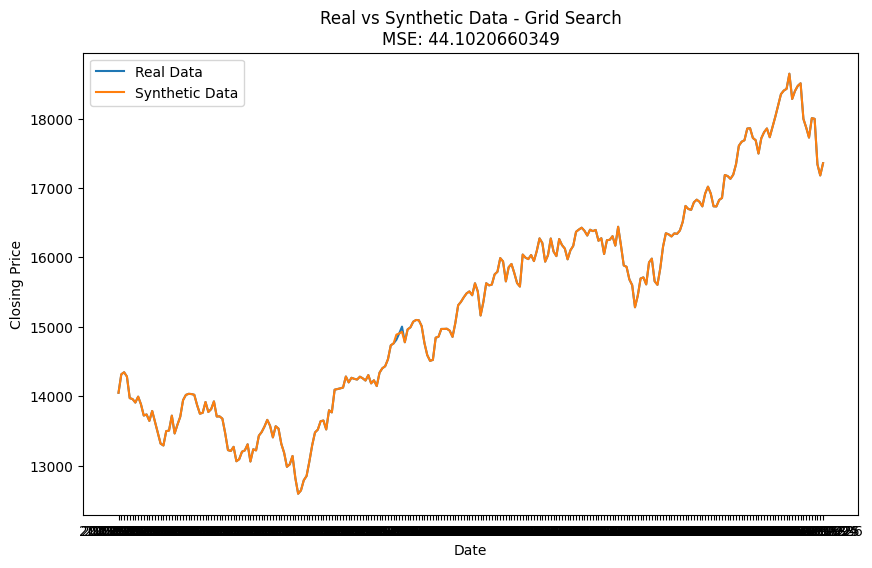

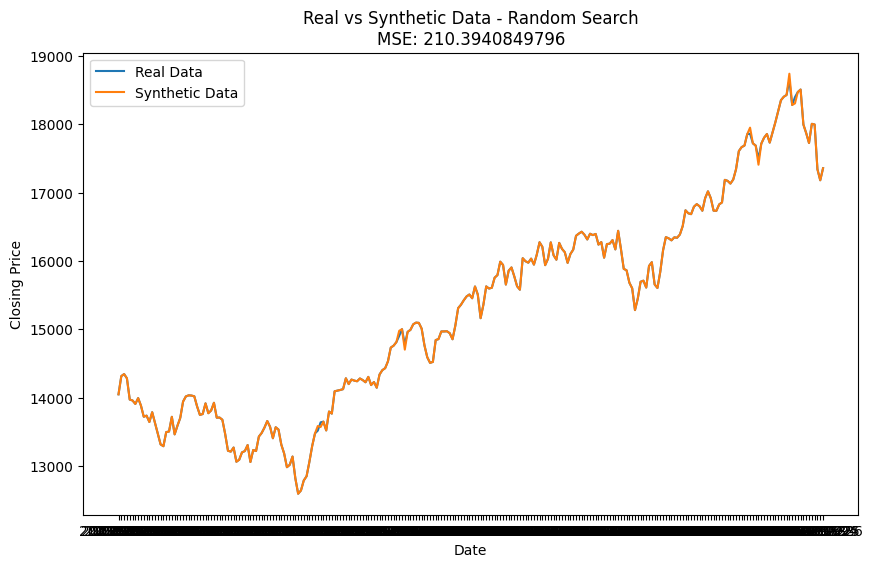

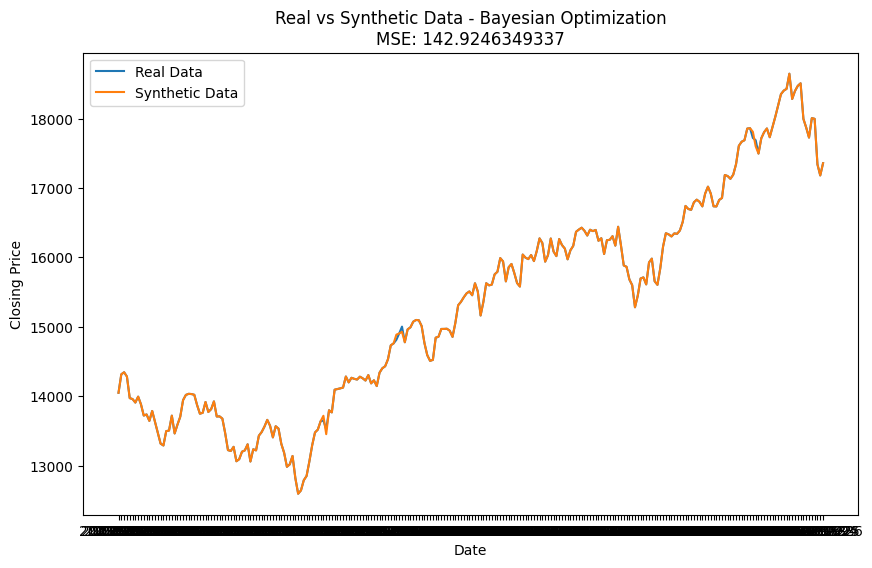

Greedy Search Best Params: Fundamental value = 140, Trend length = 7
Greedy Search Best Distance: 80.8778


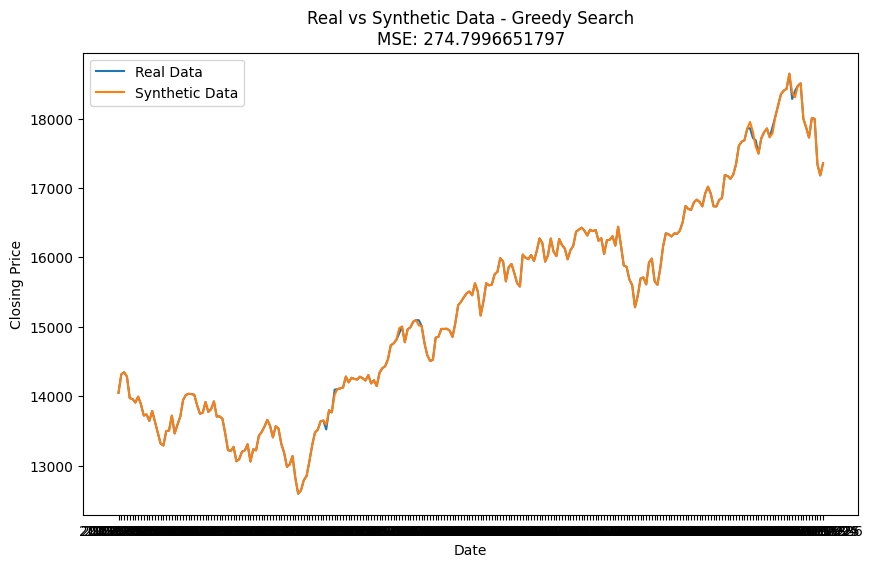


Reinforcement Learning for IXIC dataset


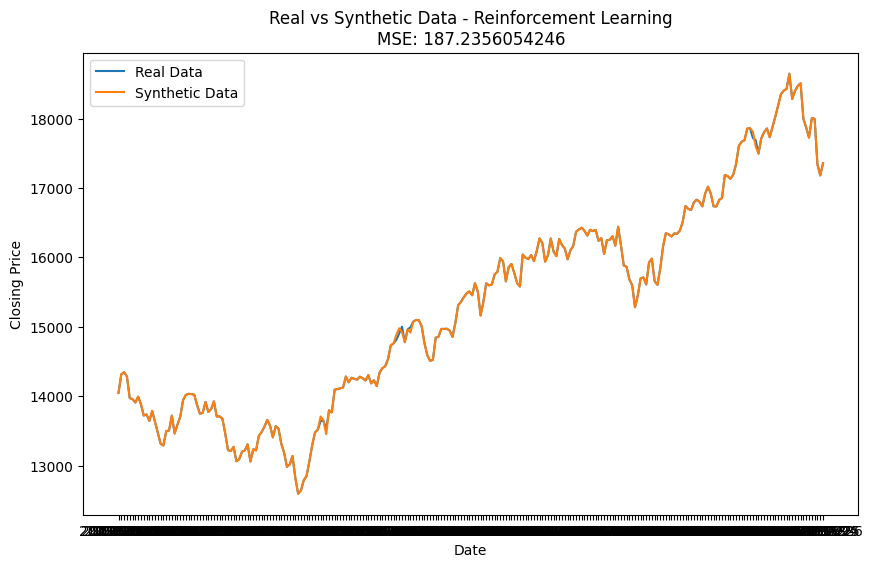

Summary for IXIC:
Grid Search MSE: 44.1020660349
Random Search MSE: 210.3940849796
Bayesian Optimization MSE: 142.9246349337
Greedy Search MSE: 274.7996651797

Evaluating performance for dataset: SPX


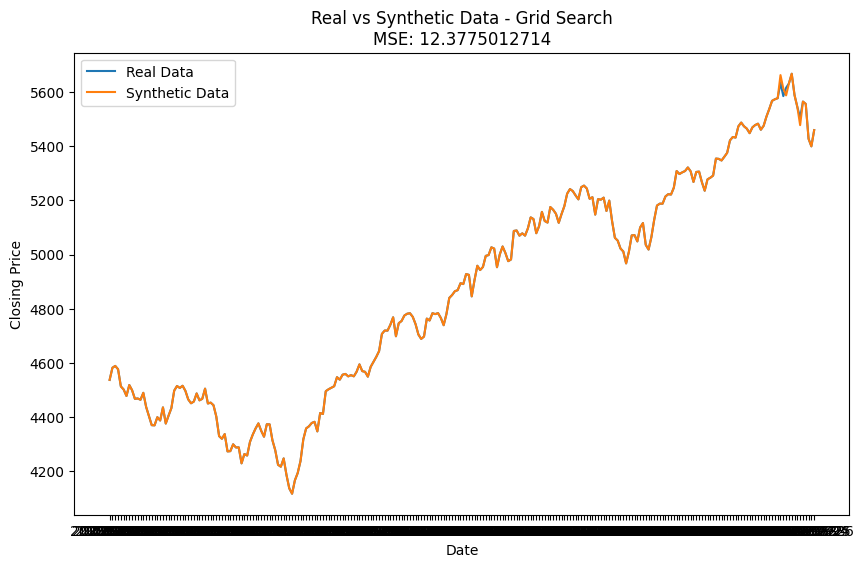

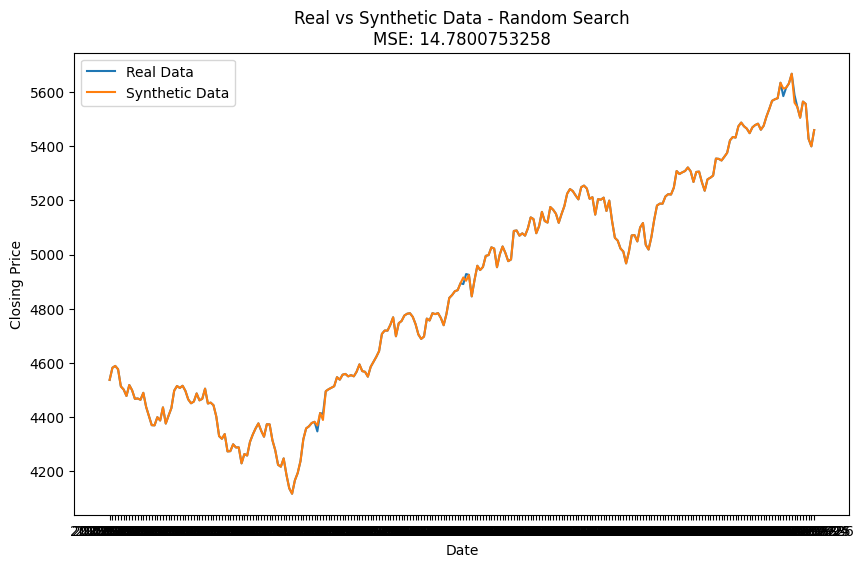

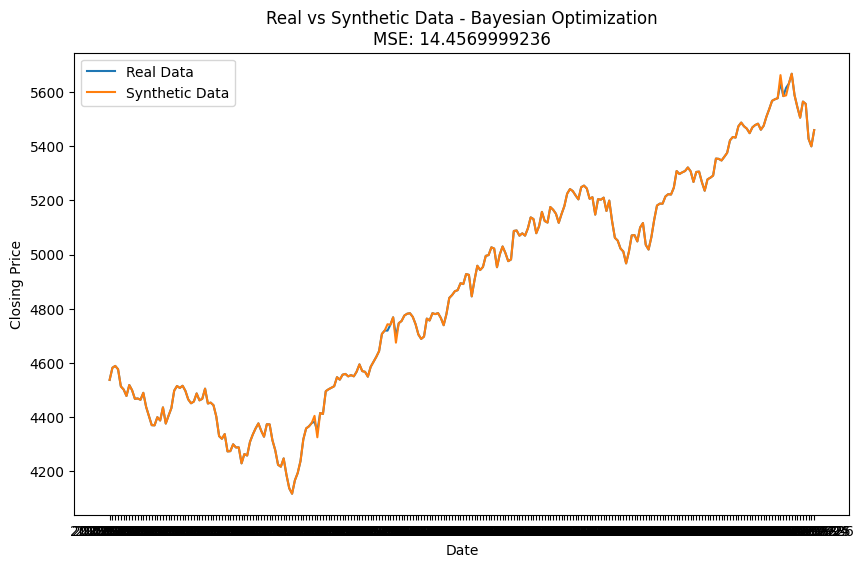

Greedy Search Best Params: Fundamental value = 150, Trend length = 3
Greedy Search Best Distance: 0.0000


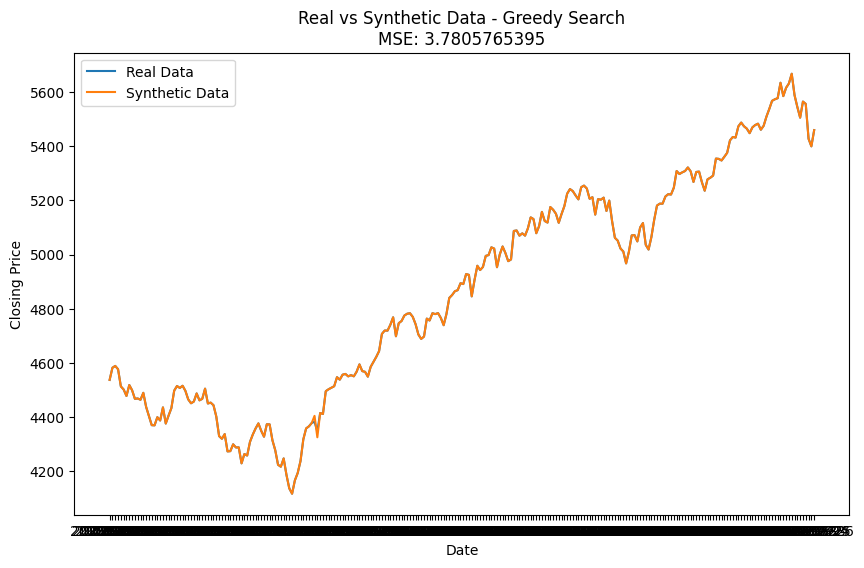


Reinforcement Learning for SPX dataset


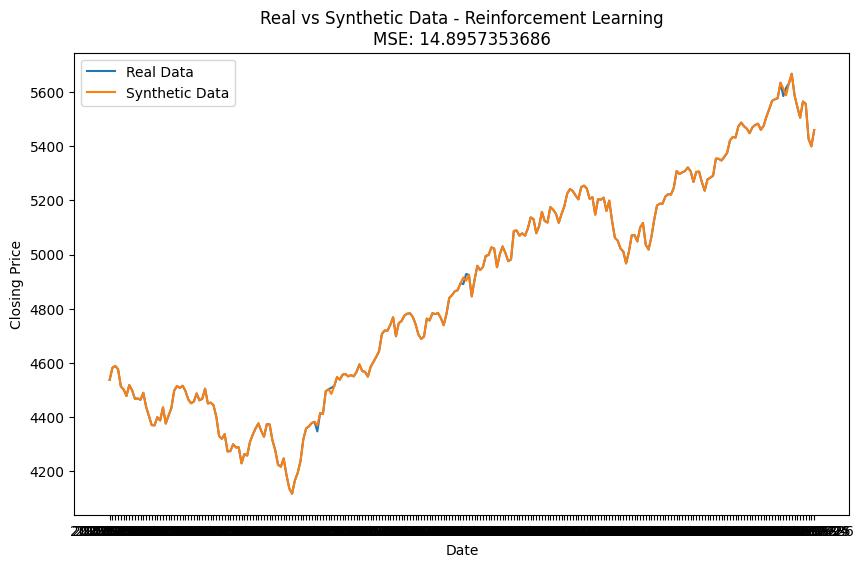

Summary for SPX:
Grid Search MSE: 12.3775012714
Random Search MSE: 14.7800753258
Bayesian Optimization MSE: 14.4569999236
Greedy Search MSE: 3.7805765395
time: 43.4 s (started: 2024-09-09 09:38:06 +00:00)


In [33]:
import matplotlib.pyplot as plt

# Function to evaluate and plot results
def evaluate_and_plot(trader_classes, real_data, method_name, best_params):
    # Set the best parameters for the traders
    fundamental_value, sensitivity, trend_length = best_params
    trader_classes[0].fundamental_value = fundamental_value
    trader_classes[0].sensitivity = sensitivity
    trader_classes[1].trend_length = trend_length

    # Generate synthetic data using the best parameters
    synthetic_data = generate_synthetic_data(trader_classes, real_data)

    # Calculate distance (MSE) between real and synthetic data
    distance = distance_function(real_data, synthetic_data)

    # Plot the real and synthetic closing prices
    plt.figure(figsize=(10, 6))
    plt.plot(real_data['Date'], real_data['Close'], label='Real Data')
    plt.plot(synthetic_data['Date'], synthetic_data['Close'], label='Synthetic Data')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title(f'Real vs Synthetic Data - {method_name}\nMSE: {distance:.10f}')
    plt.legend()
    plt.show()

    return distance

# Modified function for greedy search to return best parameters
def greedy_search_with_plot(trader_classes, real_data):
    best_distance = float('inf')
    best_params = None

    fundamental_values = [140, 150, 160]
    trend_lengths = [3, 5, 7]

    for fundamental_value in fundamental_values:
        for trend_length in trend_lengths:
            trader_classes[0].fundamental_value = fundamental_value
            trader_classes[1].trend_length = trend_length

            synthetic_data = generate_synthetic_data(trader_classes, real_data)
            distance = distance_function(real_data, synthetic_data)

            if distance < best_distance:
                best_distance = distance
                best_params = (fundamental_value, trend_length)

    print(f"Greedy Search Best Params: Fundamental value = {best_params[0]}, Trend length = {best_params[1]}")
    print(f"Greedy Search Best Distance: {best_distance:.4f}")

    # Plot the results
    sensitivity = trader_classes[0].sensitivity  # Retain sensitivity value
    return evaluate_and_plot(trader_classes, real_data, "Greedy Search", (best_params[0], sensitivity, best_params[1]))

# Function to train RL agent and plot results
def train_and_plot_rl(trader_classes, agent, real_data, method_name, episodes=10):
    for episode in range(episodes):
        state = 0
        done = False
        env = TradingEnvRL(real_data)
        state = env.reset()

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state

        best_action = np.argmax(agent.q_table.sum(axis=0))
        trader_classes[0].fundamental_value = 140 + best_action * 10
        trader_classes[1].trend_length = 3 + best_action * 2

    # After training, evaluate and plot results
    sensitivity = trader_classes[0].sensitivity  # Retain sensitivity value
    evaluate_and_plot(trader_classes, real_data, method_name, (trader_classes[0].fundamental_value, sensitivity, trader_classes[1].trend_length))

# Example usage of evaluation and plotting for each method
for name, real_data in datasets.items():
    print(f"\nEvaluating performance for dataset: {name}")

    # Initialize traders with default values
    fundamental_trader = FundamentalTrader(fundamental_value=150)
    momentum_trader = MomentumTrader(trend_length=3)
    random_trader = RandomTrader()
    trader_classes = [fundamental_trader, momentum_trader, random_trader]

    # Grid search best params
    grid_best_params, _ = grid_search_tuning(trader_classes, param_grid, real_data)
    grid_mse = evaluate_and_plot(trader_classes, real_data, "Grid Search", grid_best_params)

    # Random search best params
    random_best_params, _ = random_search_tuning(trader_classes, param_distributions, n_iter, real_data)
    random_mse = evaluate_and_plot(trader_classes, real_data, "Random Search", random_best_params)

    # Bayesian optimization best params
    bayesian_best_params, _ = bayesian_optimization_tuning(trader_classes, real_data)
    bayesian_mse = evaluate_and_plot(trader_classes, real_data, "Bayesian Optimization", bayesian_best_params)

    # Greedy search best params and plot
    greedy_mse = greedy_search_with_plot(trader_classes, real_data)

    # Reinforcement Learning
    print(f"\nReinforcement Learning for {name} dataset")
    agent = QLearningAgent(state_space=len(real_data), action_space=3)
    train_and_plot_rl(trader_classes, agent, real_data, "Reinforcement Learning")


    # Summary of results
    print(f"Summary for {name}:")
    print(f"Grid Search MSE: {grid_mse:.10f}")
    print(f"Random Search MSE: {random_mse:.10f}")
    print(f"Bayesian Optimization MSE: {bayesian_mse:.10f}")
    print(f"Greedy Search MSE: {greedy_mse:.10f}")



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Greedy Search Best Params: Fundamental value = 150, Trend length = 7
Greedy Search Best Distance: 0.0000
results: {'Grid Search': [53077.960174212945, 53039.18585611278, 257468.187862053, 531173.3434573506, 1045458.254295875], 'Random Search': [53137.53654927099, 53039.18585611278, 257468.187862053, 531173.3434573506, 1045458.254295875], 'Bayesian Optimization': [53570.77263742851, 53039.18585611278, 257468.187862053, 531173.3434573506, 1045458.254295875], 'Greedy Search': [52874.68187283326, 53039.18585611278, 257468.187862053, 531173.3434573506, 1045458.254295875], 'Reinforcement Learning': [52875.432339359606, 53039.18585611278, 257468.187862053, 531173.3434573506, 1045458.254295875]}


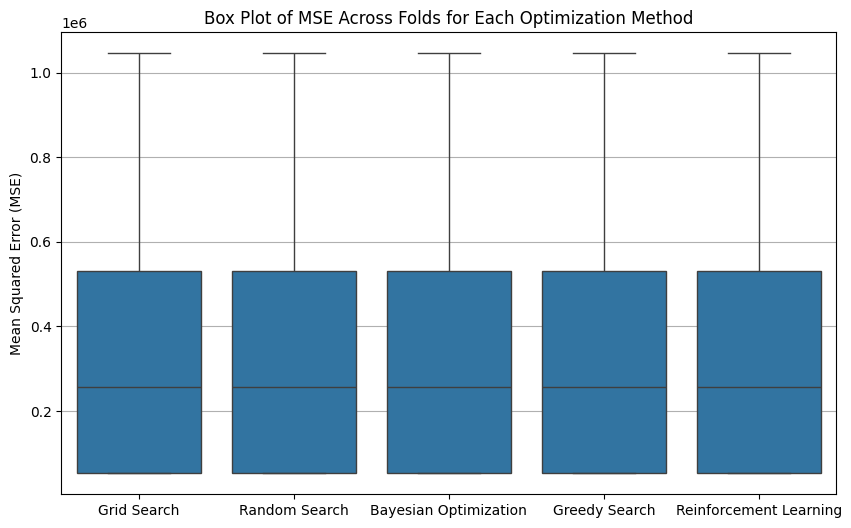

time: 7.31 s (started: 2024-09-09 09:38:49 +00:00)


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold


def greedy_search_with_plot(trader_classes, real_data, n_splits=5):
    best_distance = float('inf')
    best_params = None

    fundamental_values = [140, 150, 160]
    trend_lengths = [3, 5, 7]

    for fundamental_value in fundamental_values:
        for trend_length in trend_lengths:
            trader_classes[0].fundamental_value = fundamental_value
            trader_classes[1].trend_length = trend_length

            synthetic_data = generate_synthetic_data(trader_classes, real_data)
            distance = distance_function(real_data, synthetic_data)

            if distance < best_distance:
                best_distance = distance
                best_params = (fundamental_value, trend_length)

    print(f"Greedy Search Best Params: Fundamental value = {best_params[0]}, Trend length = {best_params[1]}")
    print(f"Greedy Search Best Distance: {best_distance:.4f}")

    # Perform cross-validation using the best parameters
    fold_mse = cross_validate(trader_classes, real_data, "Greedy Search", (best_params[0], trader_classes[0].sensitivity, best_params[1]), n_splits)

    return fold_mse  # Return the list of MSE values for each fold

def train_and_plot_rl(trader_classes, agent, real_data, method_name, episodes=10, n_splits=5):
    # Placeholder to store MSE values across folds
    fold_mse = []

    # K-Fold Cross-Validation setup
    kf = KFold(n_splits=n_splits)

    for train_index, test_index in kf.split(real_data):
        # Split data into train and test sets
        train_data, test_data = real_data.iloc[train_index].reset_index(drop=True), real_data.iloc[test_index].reset_index(drop=True)

        # Train the RL agent on the train set
        for episode in range(episodes):
            state = 0
            done = False
            env = TradingEnvRL(train_data)
            state = env.reset()

            while not done:
                action = agent.choose_action(state)
                next_state, reward, done, _ = env.step(action)
                agent.update(state, action, reward, next_state)
                state = next_state

            best_action = np.argmax(agent.q_table.sum(axis=0))
            trader_classes[0].fundamental_value = 140 + best_action * 10
            trader_classes[1].trend_length = 3 + best_action * 2

        # Generate synthetic data on the train set
        synthetic_data = generate_synthetic_data(trader_classes, train_data)

        # Adjust the synthetic data to match the test set length
        synthetic_data = synthetic_data.iloc[:len(test_data)].reset_index(drop=True)

        # Evaluate the model on the test set
        mse = distance_function(test_data, synthetic_data)
        fold_mse.append(mse)

    return fold_mse  # Return the list of MSE values for each fold

def cross_validate(trader_classes, real_data, method_name, best_params, n_splits=5):
    # K-Fold Cross-Validation setup
    kf = KFold(n_splits=n_splits)
    fold_mse = []

    for train_index, test_index in kf.split(real_data):
        # Split data into train and test sets
        train_data, test_data = real_data.iloc[train_index].reset_index(drop=True), real_data.iloc[test_index].reset_index(drop=True)

        # Set best parameters for the traders
        fundamental_value, sensitivity, trend_length = best_params
        trader_classes[0].fundamental_value = fundamental_value
        trader_classes[0].sensitivity = sensitivity
        trader_classes[1].trend_length = trend_length

        # Generate synthetic data on the train set
        synthetic_data = generate_synthetic_data(trader_classes, train_data)

        # Adjust the synthetic data to match the test set length
        synthetic_data = synthetic_data.iloc[:len(test_data)].reset_index(drop=True)

        # Evaluate the model on the test set
        mse = distance_function(test_data, synthetic_data)
        fold_mse.append(mse)

    return fold_mse  # Return list of MSE values

# Dictionary to store MSE values for each method across folds
results = {}

# Example cross-validation calls (ensure all methods return a list of MSE values)
results['Grid Search'] = cross_validate(trader_classes, real_data, "Grid Search", grid_best_params)
results['Random Search'] = cross_validate(trader_classes, real_data, "Random Search", random_best_params)
results['Bayesian Optimization'] = cross_validate(trader_classes, real_data, "Bayesian Optimization", bayesian_best_params)
results['Greedy Search'] = greedy_search_with_plot(trader_classes, real_data)  # Ensure this returns a list of MSEs
results['Reinforcement Learning'] = train_and_plot_rl(trader_classes, agent, real_data, "Reinforcement Learning")  # Now returns a list of MSEs

print(f"results: {results}")

# Prepare data for seaborn box plot
mse_values = []
methods_labels = []
for method, mse_list in results.items():
    mse_values.extend(mse_list)  # Collect all MSE values
    methods_labels.extend([method] * len(mse_list))  # Label them by method

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=methods_labels, y=mse_values)
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Box Plot of MSE Across Folds for Each Optimization Method')
plt.grid(axis='y')
plt.show()
